### Group Project
### Group 7
### Law and Order: SVD

#### Robert Kaszubski, Neelabh Pathak, Christopher Wieneke

## Surprise Models:

imports:

In [1]:
import gzip
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

In [2]:
import random
from surprise import Dataset
from surprise import Reader

#Models
from surprise import SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, SVDpp, NMF

from surprise.model_selection import cross_validate, GridSearchCV, train_test_split, KFold, ShuffleSplit
from surprise import accuracy

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Open dataset json file. Using only first 100,000 rows.

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Movies_and_TV_5.json.gz')
#df = df.head(1000000)

In [4]:
df_review = df.head(100000)

#### Exploratory:

In [5]:
df.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"11 9, 2012",A2M1CU2IRZG0K9,0005089549,{'Format:': ' VHS Tape'},Terri,So sorry I didn't purchase this years ago when...,Amazing!,1352419200,NaN,NaN
1,5.0,True,"12 30, 2011",AFTUJYISOFHY6,0005089549,{'Format:': ' VHS Tape'},Melissa D. Abercrombie,Believe me when I tell you that you will recei...,Great Gospel VHS of the Cathedrals!,1325203200,NaN,NaN
2,5.0,True,"04 21, 2005",A3JVF9Y53BEOGC,000503860X,{'Format:': ' DVD'},Anthony Thompson,"I have seen X live many times, both in the ear...",A great document of a great band,1114041600,11,NaN
3,5.0,True,"04 6, 2005",A12VPEOEZS1KTC,000503860X,{'Format:': ' DVD'},JadeRain,"I was so excited for this! Finally, a live co...",YES!! X LIVE!!,1112745600,5,NaN
4,5.0,True,"12 3, 2010",ATLZNVLYKP9AZ,000503860X,{'Format:': ' DVD'},T. Fisher,X is one of the best punk bands ever. I don't ...,X have still got it,1291334400,5,NaN


We can see the different variables used in our subset of data. We will primarily be using the reviewerID (userId), the asin (Item ID), the reviewtext (for content based recommendation), and overall (the rating).

In [6]:
df.describe()

,overall,unixReviewTime
count,3.410019e+06,3.410019e+06
mean,4.221320e+00,1.384551e+09
std,1.166456e+00,1.158514e+08
min,1.000000e+00,8.810208e+08
25%,4.000000e+00,1.363046e+09
50%,5.000000e+00,1.419811e+09
75%,5.000000e+00,1.457827e+09
max,5.000000e+00,1.538352e+09


The majority of variables are strings. But we can see the distribution of the rating variables (overall). The majority of the data has a maximum rating of 5. We can see that as it's the median, so at least 50% of the data is 5's. The 25 percentile is already a 4, so the majority of reviews in this batch are very positive. As we can see in the bar chart below:

Text(0, 0.5, 'Count')

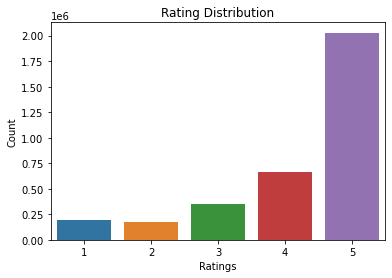

In [7]:
import seaborn as sns
# sns.set_theme(style="whitegrid")
values = [df['overall'].value_counts()[1.0],df['overall'].value_counts()[2.0],df['overall'].value_counts()[3.0],df['overall'].value_counts()[4.0],df['overall'].value_counts()[5.0]]
bins_list = [1,2,3,4,5]
ax = sns.barplot(x=bins_list, y=values)
ax.set(title='Rating Distribution')
ax.set_xlabel("Ratings")
ax.set_ylabel("Count")

In [8]:
df['overall'].value_counts()

5.0    2028791
4.0     665920
3.0     349700
1.0     193169
2.0     172439
Name: overall, dtype: int64

Renaming columns and removing unneeded variables:

In [9]:
columns = ['reviewerID','asin','overall']
df = df[columns]
df.columns = ['userID', 'itemID', 'rating']

We initially only used the first 1,000,000 rows. Instead we decided to convert the core5 dataset into core15 meaning that each user has rated 15 items and each item has 15 ratings:

In [10]:
#function to turn 5 core into k core.
def narrow(df,name='userID', name2='itemID',k=10):

    d1 = len(df)
    users = df.groupby([name])[name2].count().reset_index()
    userList = list(set(users[users[name2] > k][name]))

    df2 = df[df[name].isin(userList)]

    items = df2.groupby([name2])[name].count().reset_index()
    itemList = list(set(items[items[name] > k][name2]))

    df3 = df2[df2[name2].isin(itemList)]

    if len(df3) == len(df2):
        return df3

    else:
        return narrow(df3,name,name2)

In [11]:
df = narrow(df, k = 15)
len(df)

1246518

Rating Distribution of the Core 15 subset should be similar:

Text(0, 0.5, 'Count')

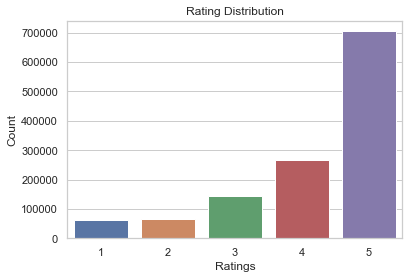

In [12]:
sns.set_theme(style="whitegrid")
values = [df['rating'].value_counts()[1.0],df['rating'].value_counts()[2.0],df['rating'].value_counts()[3.0],df['rating'].value_counts()[4.0],df['rating'].value_counts()[5.0]]
bins_list = [1,2,3,4,5]
ax = sns.barplot(x=bins_list, y=values)
ax.set(title='Rating Distribution')
ax.set_xlabel("Ratings")
ax.set_ylabel("Count")

#### Splitting Data:

In [13]:
#function to split data into training testing
def prep_data(df):
  reader = Reader(rating_scale=(1, 5))
  
  data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)
  my_seed = 0
  random.seed(my_seed)
  np.random.seed(my_seed)

  raw_ratings = data.raw_ratings

  # shuffle ratings if you want
  random.shuffle(raw_ratings)

  # A = 80% of the data, B = 20% of the data
  threshold = int(.8 * len(raw_ratings))
  A_raw_ratings = raw_ratings[:threshold]
  B_raw_ratings = raw_ratings[threshold:]

  data.raw_ratings = A_raw_ratings

  return data, B_raw_ratings

In [14]:
# setting up data
data, B_raw_ratings = prep_data(df)


In [15]:
# setting up place holder for results
columns=['algo','best_param','biased_rmse','un-biased_rmse','model_exec_ts']
df_results = pd.DataFrame(columns=columns)
df_results
results = []
#df for precision recall results @k 1 to 30
df_results_pr = pd.DataFrame(columns=['algo','metric','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30'])

In [16]:
df.shape

(1246518, 3)

Grid Search helper function

In [17]:
from collections import defaultdict

In [18]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [19]:
def grid_search_cv(algo, param_grid, cv, measure, data, hold_out_data):
  print('Grid Search...{0}'.format(algo))
  grid_search = GridSearchCV(algo, 
                            param_grid, 
                            measures=[measure], 
                            cv=cv)
  grid_search.fit(data)
  
  # grid search
  print("Grid Search...Complete")
  print("Best Param of SVD",grid_search.best_params[measure])
  best_params_dict = grid_search.best_params[measure]
  algo = grid_search.best_estimator[measure]
  
  # retrain on the whole set A
  trainset = data.build_full_trainset()
  algo.fit(trainset)
  print("model traininig complete.")
  
  # Compute biased accuracy on trainData
  pb = algo.test(trainset.build_testset())
  print('Biased accuracy on A,', end=' ')
  baised_accuracy = accuracy.rmse(pb)
  
  
  # Compute unbiased accuracy on testData
  testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
  pub = algo.test(testset)
    
  #calculate precision recalls @k for k 1 to 15
  p = []
  r = []
  for k in range(1,31):
      precisions, recalls = precision_recall_at_k(pub, k=k, threshold=4)
      precision = (sum(prec for prec in precisions.values()) / len(precisions))
      recall = (sum(rec for rec in recalls.values()) / len(recalls))
      p.append(precision)
      r.append(recall)
      
    
  print('Unbiased accuracy on B,', end=' ')
  unbaised_accuracy = accuracy.rmse(pub)
  

  return unbaised_accuracy, baised_accuracy, best_params_dict , pub, p, r

#### Matrix Factorization Models:

SVD:

In [20]:
# grid search 
algo=SVD
# param_grid={'n_factors': [1,5,10,15,20],
#             'lr_all': [0.005,0.01],
#             'reg_all':[0.02,0.1,0.5]}

# best parameter for SVD
param_grid={'n_factors': [1],
            'lr_all': [0.01],
            'reg_all':[0.1]} 

cv=3
measure="rmse"
results = []
unbaised_accuracy, \
    baised_accuracy, \
      best_params_dict, pred_svd, p, r = grid_search_cv(algo, 
                                        param_grid, 
                                        cv, 
                                        measure,
                                        data,
                                        B_raw_ratings
                                        )

df_results.loc[len(df_results.index)] = ["SVD", 
                best_params_dict, 
                baised_accuracy, 
                unbaised_accuracy,
                datetime.datetime.now()]
df_results_pr.loc[len(df_results_pr.index)] = ["SVD","precision"]+p
df_results_pr.loc[len(df_results_pr.index)] = ["SVD","recall"]+r

Grid Search...<class 'surprise.prediction_algorithms.matrix_factorization.SVD'>
Grid Search...Complete
Best Param of SVD {'n_factors': 1, 'lr_all': 0.01, 'reg_all': 0.1}
model traininig complete.
Biased accuracy on A, RMSE: 0.8691
Unbiased accuracy on B, RMSE: 0.9182


In [21]:
df_results

,algo,best_param,biased_rmse,un-biased_rmse,model_exec_ts
0,SVD,"{'n_factors': 1, 'lr_all': 0.01, 'reg_all': 0.1}",0.869096,0.918211,2022-03-18 16:37:23.113736


In [22]:
df_results_pr

,algo,metric,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
0,SVD,precision,0.778426,0.770209,0.764663,0.760706,0.758745,0.757150,0.756064,0.755447,...,0.753612,0.753590,0.753564,0.753540,0.753519,0.753507,0.753477,0.753461,0.753447,0.753445
1,SVD,recall,0.248225,0.414868,0.522730,0.589079,0.630046,0.654626,0.669817,0.679744,...,0.706742,0.707123,0.707449,0.707721,0.707970,0.708187,0.708362,0.708524,0.708665,0.708802


SVDpp:

In [23]:
# grid search 
algo=SVDpp
# param_grid={'n_factors': [1,5,10,15,20],
#             'lr_all': [0.005,0.01],
#             'reg_all':[0.02,0.1,0.5]}

# best parameter for SVDpp
param_grid={'n_factors': [1],
            'lr_all': [0.01],
            'reg_all':[0.1]}
cv=3
measure="rmse"
results = []
unbaised_accuracy, \
    baised_accuracy, \
      best_params_dict, pred_svd, p, r = grid_search_cv(algo, 
                                        param_grid, 
                                        cv, 
                                        measure,
                                        data,
                                        B_raw_ratings
                                        )

df_results.loc[len(df_results.index)] = ["SVDpp", 
                best_params_dict, 
                baised_accuracy, 
                unbaised_accuracy,
                datetime.datetime.now()]
df_results_pr.loc[len(df_results_pr.index)] = ["SVDpp","precision"]+p
df_results_pr.loc[len(df_results_pr.index)] = ["SVDpp","recall"]+r

Grid Search...<class 'surprise.prediction_algorithms.matrix_factorization.SVDpp'>
Grid Search...Complete
Best Param of SVD {'n_factors': 1, 'lr_all': 0.01, 'reg_all': 0.1}
model traininig complete.
Biased accuracy on A, RMSE: 0.8674
Unbiased accuracy on B, RMSE: 0.9177


NMF:

In [24]:
# grid search 
algo=NMF
# param_grid={'n_factors': [1,5,10,15,20],
#             'reg_pu': [0.06,0.10],
#             'reg_qi':[0.06,0.10],
#             'reg_bu':[0.06,0.10],
#             'lr_bi': [0.005,0.001],
#             'lr_bu':[0.005,0.001]}

# best param for NMF
param_grid = {'n_factors': [20],
            'reg_pu': [0.06],
            'reg_qi':[0.10],
            'reg_bu':[0.06],
            'lr_bi': [0.001],
            'lr_bu':[0.001]}

cv=3
measure="rmse"
results = []
unbaised_accuracy, \
    baised_accuracy, \
      best_params_dict, pred_svd, p, r = grid_search_cv(algo, 
                                        param_grid, 
                                        cv, 
                                        measure,
                                        data,
                                        B_raw_ratings
                                        )

df_results.loc[len(df_results.index)] = ["NMF", 
                best_params_dict, 
                baised_accuracy, 
                unbaised_accuracy,
                datetime.datetime.now()]
df_results_pr.loc[len(df_results_pr.index)] = ["NMF","precision"]+p
df_results_pr.loc[len(df_results_pr.index)] = ["NMF","recall"]+r

Grid Search...<class 'surprise.prediction_algorithms.matrix_factorization.NMF'>
Grid Search...Complete
Best Param of SVD {'n_factors': 20, 'reg_pu': 0.06, 'reg_qi': 0.1, 'reg_bu': 0.06, 'lr_bi': 0.001, 'lr_bu': 0.001}
model traininig complete.
Biased accuracy on A, RMSE: 0.6338
Unbiased accuracy on B, RMSE: 0.9434


#### KNN Models:

KNNBasic:

In [25]:
# grid search 
algo=KNNBasic

#param_grid = {'k': [1,2,3,4,5,10,15,20,25,30,35,40],
#              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
#                              'min_support': [1,2,5,10,20],
#                             'user_based': [False]}


# best param for KNNBasic
param_grid = {'k': [15],
              'sim_options': {'name': ['pearson'],
                              'min_support': [20],
                              'user_based': [False]}
              }

cv=3
measure="rmse"
results = []
unbaised_accuracy, \
    baised_accuracy, \
      best_params_dict, pred_svd, p, r = grid_search_cv(algo, 
                                        param_grid, 
                                        cv, 
                                        measure,
                                        data,
                                        B_raw_ratings
                                        )

df_results.loc[len(df_results.index)] = ["KNNBasic", 
                best_params_dict, 
                baised_accuracy, 
                unbaised_accuracy,
                datetime.datetime.now()]
df_results_pr.loc[len(df_results_pr.index)] = ["KNNBasic","precision"]+p
df_results_pr.loc[len(df_results_pr.index)] = ["KNNBasic","recall"]+r

Grid Search...<class 'surprise.prediction_algorithms.knns.KNNBasic'>
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Grid Search...Complete
Best Param of SVD {'k': 15, 'sim_options': {'name': 'pearson', 'min_support': 20, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
model traininig complete.
Biased accuracy on A, RMSE: 0.2987
Unbiased accuracy on B, RMSE: 1.0633


KNNWithMeans:

In [26]:
# grid search 
algo=KNNWithMeans

#param_grid = {'k': [1,2,3,4,5,10,15,20,25,30,35,40],
#              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
#                              'min_support': [1,2,5,10,20],
#                             'user_based': [False]}
#             }
            

# best param for KNNWithMeans
param_grid = {'k': [15],
              'sim_options': {'name': ['pearson'],
                              'min_support': [20],
                              'user_based': [False]}
              }


cv=3
measure="rmse"
results = []
unbaised_accuracy, \
    baised_accuracy, \
      best_params_dict, pred_svd, p, r = grid_search_cv(algo, 
                                        param_grid, 
                                        cv, 
                                        measure,
                                        data,
                                        B_raw_ratings
                                        )

df_results.loc[len(df_results.index)] = ["KNNWithMeans", 
                best_params_dict, 
                baised_accuracy, 
                unbaised_accuracy,
                datetime.datetime.now()]
df_results_pr.loc[len(df_results_pr.index)] = ["KNNWithMeans","precision"]+p
df_results_pr.loc[len(df_results_pr.index)] = ["KNNWithMeans","recall"]+r

Grid Search...<class 'surprise.prediction_algorithms.knns.KNNWithMeans'>
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Grid Search...Complete
Best Param of SVD {'k': 15, 'sim_options': {'name': 'pearson', 'min_support': 20, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
model traininig complete.
Biased accuracy on A, RMSE: 0.2845
Unbiased accuracy on B, RMSE: 0.9883


KNNWithZScore:

In [27]:
# grid search 
algo=KNNWithZScore

#param_grid = {'k': [1,2,3,4,5,10,15,20,25,30,35,40],
#              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
#                              'min_support': [1,2,5,10,20],
#                             'user_based': [False]}
#             }
            

# best param for KNNWithZScore
param_grid = {'k': [20],
              'sim_options': {'name': ['pearson'],
                              'min_support': [20],
                              'user_based': [False]}
              }


cv=3
measure="rmse"
results = []
unbaised_accuracy, \
    baised_accuracy, \
      best_params_dict, pred_svd, p, r = grid_search_cv(algo, 
                                        param_grid, 
                                        cv, 
                                        measure,
                                        data,
                                        B_raw_ratings
                                        )

df_results.loc[len(df_results.index)] = ["KNNWithZScore", 
                best_params_dict, 
                baised_accuracy, 
                unbaised_accuracy,
                datetime.datetime.now()]
df_results_pr.loc[len(df_results_pr.index)] = ["KNNWithZScore","precision"]+p
df_results_pr.loc[len(df_results_pr.index)] = ["KNNWithZScore","recall"]+r

Grid Search...<class 'surprise.prediction_algorithms.knns.KNNWithZScore'>
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Grid Search...Complete
Best Param of SVD {'k': 20, 'sim_options': {'name': 'pearson', 'min_support': 20, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
model traininig complete.
Biased accuracy on A, RMSE: 0.2870
Unbiased accuracy on B, RMSE: 0.9880


KNNBaseline (als)

In [28]:
# grid search 
algo=KNNBaseline

#sim_options were optimized first, followed by bsl options, and k. Running it all at the same time would take too long.
#param_grid = {'k': [1,2,3,4,5,10,15,20,25,30,35,40],
#              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
#                              'min_support': [1,2,5,10,20],
#                             'user_based': [False]},
#              'bsl_options': {'method': ['als'],
#                             'n_epochs': [1,2,5,10,20,50],
#                             'reg_i': [1,2,5,10,15,20],
#                             'reg_u': [1,2,5,10,15,20]}
#             }
            

# best param for KNNBaseline
param_grid = {'k': [20],
            'sim_options': {'name': ['pearson'],
                            'min_support': [20],
                            'user_based': [False]},
             'bsl_options': {'method': ['als'],
                             'n_epochs': [50],
                             'reg_i': [2],
                             'reg_u': [2]}
             }
cv=3
measure="rmse"
results = []
unbaised_accuracy, \
    baised_accuracy, \
      best_params_dict, pred_svd, p, r = grid_search_cv(algo, 
                                        param_grid, 
                                        cv, 
                                        measure,
                                        data,
                                        B_raw_ratings
                                        )

df_results.loc[len(df_results.index)] = ["KNNBaseline_ALS", 
                best_params_dict, 
                baised_accuracy, 
                unbaised_accuracy,
                datetime.datetime.now()]
df_results_pr.loc[len(df_results_pr.index)] = ["KNNBaseline_ALS","precision"]+p
df_results_pr.loc[len(df_results_pr.index)] = ["KNNBaseline_ALS","recall"]+r

Grid Search...<class 'surprise.prediction_algorithms.knns.KNNBaseline'>
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Grid Search...Complete
Best Param of SVD {'k': 20, 'sim_options': {'name': 'pearson', 'min_support': 20, 'user_based': False}, 'bsl_options': {'method': 'als', 'n_epochs': 50, 'reg_i': 2, 'reg_u': 2}}
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
model traininig complete.
Biased accuracy on A, RMSE: 0.2850
Unbiased accuracy on B, RMSE: 0.9033


KNNBaseline (sgd)

In [29]:
# grid search 
algo=KNNBaseline

#sim_options were optimized first, followed by bsl options, and k. Running it all at the same time would take too long.
#param_grid = {'k': [1,2,3,4,5,10,15,20,25,30,35,40],
#              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
#                              'min_support': [1,2,5,10,20],
#                             'user_based': [False]},
#              'bsl_options': {'method': ['als'],
#                             'n_epochs': [1,2,5,10,20,50],
#                             'reg': [.001,.01,.02,.1,1],
#                             'learning_rate': [.00005,.0005,.005,.05,.5]}
#             }
            

# best param for KNNBaseline
param_grid = {'k': [15],
              'sim_options': {'name': ['pearson'],
                              'min_support': [20],
                             'user_based': [False]},
              'bsl_options': {'method': ['sgd'],
                              'n_epochs': [50],
                              'reg': [.1],
                              'learning_rate': [.005]}
                              }
             

cv=3
measure="rmse"
results = []
unbaised_accuracy, \
    baised_accuracy, \
      best_params_dict, pred_svd, p, r = grid_search_cv(algo, 
                                        param_grid, 
                                        cv, 
                                        measure,
                                        data,
                                        B_raw_ratings
                                        )

df_results.loc[len(df_results.index)] = ["KNNBaseline_SGD", 
                best_params_dict, 
                baised_accuracy, 
                unbaised_accuracy,
                datetime.datetime.now()]
df_results_pr.loc[len(df_results_pr.index)] = ["KNNBaseline_SGD","precision"]+p
df_results_pr.loc[len(df_results_pr.index)] = ["KNNBaseline_SGD","recall"]+r

Grid Search...<class 'surprise.prediction_algorithms.knns.KNNBaseline'>
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Grid Search...Complete
Best Param of SVD {'k': 15, 'sim_options': {'name': 'pearson', 'min_support': 20, 'user_based': False}, 'bsl_options': {'method': 'sgd', 'n_epochs': 50, 'reg': 0.1, 'learning_rate': 0.005}}
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
model traininig complete.
Biased accuracy on A, RMSE: 0.2837
Unbiased accuracy on B, RMSE: 0.9051


#### Slope One

In [30]:
algo=SlopeOne
      

param_grid = {
             }

cv=3
measure="rmse"
results = []
unbaised_accuracy, \
    baised_accuracy, \
      best_params_dict, pred_svd, p, r = grid_search_cv(algo, 
                                        param_grid, 
                                        cv, 
                                        measure,
                                        data,
                                        B_raw_ratings
                                        )

df_results.loc[len(df_results.index)] = ["SlopeOne", 
                best_params_dict, 
                baised_accuracy, 
                unbaised_accuracy,
                datetime.datetime.now()]
df_results_pr.loc[len(df_results_pr.index)] = ["SlopeOne","precision"]+p
df_results_pr.loc[len(df_results_pr.index)] = ["SlopeOne","recall"]+r

Grid Search...<class 'surprise.prediction_algorithms.slope_one.SlopeOne'>
Grid Search...Complete
Best Param of SVD {}
model traininig complete.
Biased accuracy on A, RMSE: 0.4435
Unbiased accuracy on B, RMSE: 0.9499


#### Co Clustering

In [31]:
# grid search 
algo=CoClustering


            
# best param for CoClustering
param_grid = {'n_epochs': [11],
              'n_cltr_i':[3],
              'n_cltr_u':[2]
             }

cv=3
measure="rmse"
results = []
unbaised_accuracy, \
    baised_accuracy, \
      best_params_dict, pred_svd, p, r = grid_search_cv(algo, 
                                        param_grid, 
                                        cv, 
                                        measure,
                                        data,
                                        B_raw_ratings
                                        )

df_results.loc[len(df_results.index)] = ["CoClustering", 
                best_params_dict, 
                baised_accuracy, 
                unbaised_accuracy,
                datetime.datetime.now()]
df_results_pr.loc[len(df_results_pr.index)] = ["CoClustering","precision"]+p
df_results_pr.loc[len(df_results_pr.index)] = ["CoClustering","recall"]+r

Grid Search...<class 'surprise.prediction_algorithms.co_clustering.CoClustering'>
Grid Search...Complete
Best Param of SVD {'n_epochs': 11, 'n_cltr_i': 3, 'n_cltr_u': 2}
model traininig complete.
Biased accuracy on A, RMSE: 0.8749
Unbiased accuracy on B, RMSE: 0.9519


### Evaluation RESULTS

In [32]:
df_results

,algo,best_param,biased_rmse,un-biased_rmse,model_exec_ts
0,SVD,"{'n_factors': 1, 'lr_all': 0.01, 'reg_all': 0.1}",0.869096,0.918211,2022-03-18 16:37:23.113736
1,SVDpp,"{'n_factors': 1, 'lr_all': 0.01, 'reg_all': 0.1}",0.867387,0.917741,2022-03-18 16:53:30.085732
2,NMF,"{'n_factors': 20, 'reg_pu': 0.06, 'reg_qi': 0....",0.633783,0.943373,2022-03-18 16:57:08.372618
3,KNNBasic,"{'k': 15, 'sim_options': {'name': 'pearson', '...",0.298730,1.063311,2022-03-18 17:07:13.483841
4,KNNWithMeans,"{'k': 15, 'sim_options': {'name': 'pearson', '...",0.284455,0.988297,2022-03-18 17:16:42.100305
5,KNNWithZScore,"{'k': 20, 'sim_options': {'name': 'pearson', '...",0.287022,0.988013,2022-03-18 17:26:10.342948
6,KNNBaseline_ALS,"{'k': 20, 'sim_options': {'name': 'pearson', '...",0.285028,0.903295,2022-03-18 17:36:14.927870
7,KNNBaseline_SGD,"{'k': 15, 'sim_options': {'name': 'pearson', '...",0.283718,0.905093,2022-03-18 17:47:35.244981
8,SlopeOne,{},0.443522,0.949918,2022-03-18 17:50:35.603687
9,CoClustering,"{'n_epochs': 11, 'n_cltr_i': 3, 'n_cltr_u': 2}",0.874933,0.951862,2022-03-18 17:51:51.610671


Precision/Recall Results for K=1 to K=30.

In [33]:
df_results_pr

,algo,metric,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
0,SVD,precision,0.778426,0.770209,0.764663,0.760706,0.758745,0.757150,0.756064,0.755447,...,0.753612,0.753590,0.753564,0.753540,0.753519,0.753507,0.753477,0.753461,0.753447,0.753445
1,SVD,recall,0.248225,0.414868,0.522730,0.589079,0.630046,0.654626,0.669817,0.679744,...,0.706742,0.707123,0.707449,0.707721,0.707970,0.708187,0.708362,0.708524,0.708665,0.708802
2,SVDpp,precision,0.778759,0.770683,0.764778,0.761050,0.758867,0.757406,0.756344,0.755754,...,0.753913,0.753880,0.753860,0.753840,0.753820,0.753807,0.753783,0.753772,0.753753,0.753748
3,SVDpp,recall,0.248395,0.415227,0.522707,0.589233,0.630028,0.654659,0.669930,0.679843,...,0.706818,0.707189,0.707519,0.707796,0.708046,0.708266,0.708445,0.708611,0.708751,0.708887
4,NMF,precision,0.783443,0.776724,0.772910,0.770058,0.768196,0.766989,0.766253,0.765883,...,0.764482,0.764441,0.764408,0.764400,0.764386,0.764376,0.764367,0.764363,0.764345,0.764334
5,NMF,recall,0.249464,0.411891,0.514914,0.577397,0.615273,0.637960,0.652051,0.661086,...,0.685850,0.686190,0.686476,0.686740,0.686971,0.687162,0.687327,0.687482,0.687609,0.687730
6,KNNBasic,precision,0.837275,0.825872,0.819865,0.815569,0.813824,0.813039,0.812424,0.811964,...,0.810519,0.810491,0.810476,0.810451,0.810429,0.810416,0.810409,0.810390,0.810389,0.810371
7,KNNBasic,recall,0.280711,0.487692,0.631676,0.723636,0.781726,0.817964,0.840881,0.855671,...,0.897369,0.898015,0.898574,0.899047,0.899488,0.899859,0.900204,0.900498,0.900791,0.901026
8,KNNWithMeans,precision,0.859597,0.846529,0.838538,0.834622,0.832383,0.830967,0.830090,0.829460,...,0.827796,0.827771,0.827762,0.827730,0.827713,0.827695,0.827685,0.827665,0.827657,0.827648
9,KNNWithMeans,recall,0.283922,0.466016,0.576352,0.641505,0.679639,0.701929,0.715723,0.724545,...,0.748691,0.749043,0.749352,0.749608,0.749840,0.750044,0.750223,0.750373,0.750518,0.750643


Based on RMSE, the top models are KNNBaseline (using ALS), SVDpp, and SVD.

Lets plot these model's precisions and recalls.

SVD:

In [34]:
svd_pre = list(df_results_pr.loc[0])[2:]
svd_rec = list(df_results_pr.loc[1])[2:]

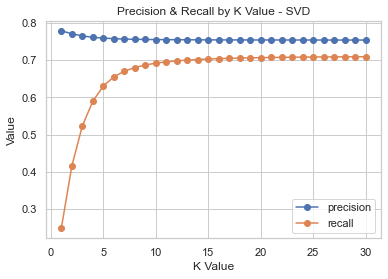

In [35]:
plt.plot(range(1,31),svd_pre,range(1,31),svd_rec,marker='o')
plt.title('Precision & Recall by K Value - SVD')
plt.legend(labels=['precision','recall'])
plt.xlabel('K Value')
plt.ylabel('Value')
plt.show()

SVDpp:

In [36]:
svdpp_pre = list(df_results_pr.loc[2])[2:]
svdpp_rec = list(df_results_pr.loc[3])[2:]

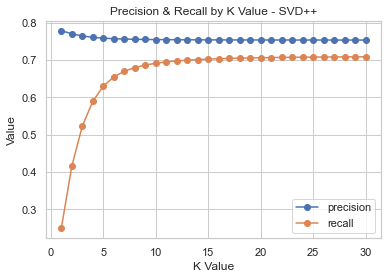

In [37]:
plt.plot(range(1,31),svdpp_pre,range(1,31),svdpp_rec,marker='o')
plt.title('Precision & Recall by K Value - SVD++')
plt.legend(labels=['precision','recall'])
plt.xlabel('K Value')
plt.ylabel('Value')
plt.show()

KNNBaseline:

In [38]:
knnbsl_pre = list(df_results_pr.loc[12])[2:]
knnbsl_rec = list(df_results_pr.loc[13])[2:]

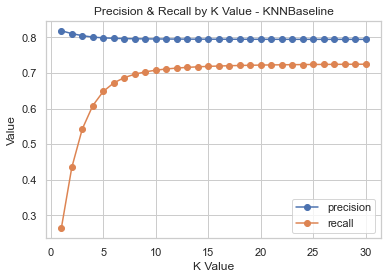

In [39]:
plt.plot(range(1,31),knnbsl_pre,range(1,31),knnbsl_rec,marker='o')
plt.title('Precision & Recall by K Value - KNNBaseline')
plt.legend(labels=['precision','recall'])
plt.xlabel('K Value')
plt.ylabel('Value')
plt.show()

Each model seems to follow a similar trajectory. They all have similar precision, recall values.

We can plot Precision by Recall for each model

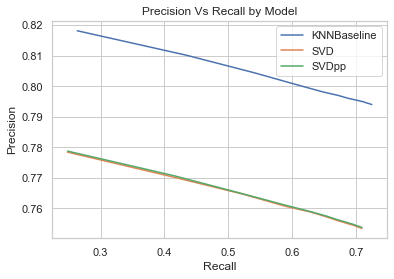

In [40]:
plt.plot(knnbsl_rec,knnbsl_pre)
plt.plot(svd_rec,svd_pre)
plt.plot(svdpp_rec,svdpp_pre)
plt.title('Precision Vs Recall by Model')
plt.legend(labels=['KNNBaseline','SVD','SVDpp'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

We can see that SVD and SVDpp have a near identical precision recall curve. KNN Basline is slightly superior with slightly larger values by about .04. Not a big difference.

Let's try recalculating precision recall using Cross Validation on the full dataset:

In [41]:
df_results_pr2 = pd.DataFrame(columns=['algo','metric','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30'])

In [42]:
kf = KFold(n_splits=5)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [43]:
algo = SVD(n_factors= 1, lr_all= 0.01, reg_all= 0.1)

In [44]:
SVD_CV_PRE = []
SVD_CV_REC = []
for k in range(1,31):
    pre = []
    rec = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=4)
        # Precision and recall can then be averaged over all users
        pre.append(sum(prec for prec in precisions.values()) / len(precisions))
        rec.append(sum(rec for rec in recalls.values()) / len(recalls))
    SVD_CV_PRE.append(sum(pre)/len(pre))
    SVD_CV_REC.append(sum(rec)/len(rec))
        

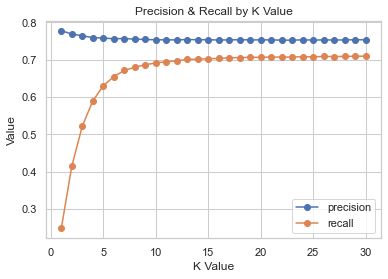

In [45]:
plt.plot(range(1,31),SVD_CV_PRE,range(1,31),SVD_CV_REC,marker='o')
plt.title('Precision & Recall by K Value')
plt.legend(labels=['precision','recall'])
plt.xlabel('K Value')
plt.ylabel('Value')
plt.show()

This netted similar results to running precision recall only on the test set. We're going to use the original results!

We can see for each model that precision/recall is fairly high at any K value greater than 5.

We're going to primarily use RMSE to evaluate our models

Top Models are:

1) KNNBaseline


2) SVD

3) SVD++

**Collaborative Filtering with Neural Network**  

In [46]:
import tensorflow as tf
from keras.regularizers import l1, l2
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Multiply, Reshape,  Flatten, Dropout, concatenate
from keras.optimizers import Adam
from time import time
from sklearn.preprocessing import OneHotEncoder
from keras import regularizers

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# limiting 100000 rows for NN
df_nn_100 = df.head(100000)
df_nn_100

Neural Network need IDs to be integer so using StringLookup to assign a Integer value to string IDs

In [ ]:
# create hash key for IDs as neural network need Integers for IDs
userID_vocab = df_nn_100.userID.unique().tolist()
itemID_vocab = df_nn_100.itemID.unique().tolist()

userID_numerical = tf.strings.to_hash_bucket_strong(
    input=df_nn_100.userID,
    num_buckets=len(df_nn_100.userID.unique()),
    key=[1, 2])

itemID_numerical = item_idxs = tf.strings.to_hash_bucket_strong(
    input=df_nn_100.itemID,
    num_buckets=len(df_nn_100.itemID.unique()),
    key=[1, 2])

In [ ]:
# creating dataframe with numerical IDs for user and item
df_nn_num = pd.DataFrame()
df_nn_num['userID'] = userID_numerical
df_nn_num['itemID'] = itemID_numerical
df_nn_num['rating'] = df_nn_100.rating.to_list()

In [ ]:
# splitting dataset
from sklearn.model_selection import train_test_split
train_nn, test_nn = train_test_split(df_nn_num, test_size=0.2, random_state=42)

In [ ]:
# define model 
def get_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = mf_dim, name = 'mf_embedding_user',
                                  embeddings_regularizer= l2(reg_mf), input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = mf_dim, name = 'mf_embedding_item',
                                  embeddings_regularizer = l2(reg_mf), input_length=1)   
#     print("layers values {}".format(layers[0]))
    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = int(layers[0]/2), name = "mlp_embedding_user",
                                   embeddings_regularizer = l2(reg_layers[0]), input_length=1)
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = int(layers[0]/2), name = 'mlp_embedding_item',
                                   embeddings_regularizer = l2(reg_layers[0]), input_length=1)   
    
    # MF part
    MF_Embedding_User(user_input)
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent]) # element-wise multiply

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Multiply()([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_layer):
#         print("layer {0}:".format(layers[idx]))
        layer = Dense(layers[idx], kernel_regularizer = l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
        mlp_vector = layer(mlp_vector)

    predict_vector = concatenate([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction=Dense(1, activation='softmax', name = "prediction")(predict_vector)
    
    model = Model(inputs=[user_input, item_input], 
                  outputs=prediction)
    
    return model

In [ ]:
## evaluate model
def evaluate_model(model,user_input,item_input,labels, testRatings,testLabels):
    #metric MAE
    #for train
    train_eval = model.evaluate(x=[user_input,item_input],y=labels,verbose=0)
    testRatingUsers=testRatings[:,0]
    testRatingItems=testRatings[:,1]
    test_eval = model.evaluate(x=[testRatingUsers,testRatingItems],y=testLabels,verbose=0)
    return train_eval, test_eval

In [ ]:
# defining seperate user,item,rating entities
user_input = np.array(train_nn.userID)
item_input = np.array(train_nn.itemID)
labels = np.array(train_nn[['rating']])
testRatings = np.array(test_nn[['userID','itemID']])
testLabels = np.array(test_nn['rating'])

In [ ]:
if __name__ == '__main__':

#################### Arguments ####################

    num_epochs = 5    
    batch_size = 256
    mf_dim = 8
    layers = [64,32,16,8]
    reg_mf = 0
    reg_layers = [0,0,0,0]
    num_negatives = 4
    learning_rate = 1e-4
    learner = 'adam'
    verbose = 1
    mf_pretrain = ''
    mlp_pretrain = ''
   
    topK = 10
    evaluation_threads = 1 

    # Loading data
    t1 = time()
    
    num_items=train_nn.itemID.shape[0]
    num_users=train_nn.userID.shape[0]

    # Build model
    model = get_model(int(num_users+1), 
                      int(num_items+1), 
                      mf_dim, 
                      layers, 
                      reg_layers, 
                      reg_mf)

    model.compile(optimizer=Adam(lr=learning_rate), 
                  loss= ['mse'], 
                  metrics=['mean_absolute_error'])


        
    # Training model
    for epoch in range(num_epochs):
        t1 = time()
  
        # Training
        hist = model.fit([user_input, item_input], #input
                         labels, # labels 
                         batch_size=batch_size, verbose=1, shuffle=True)
        t2 = time()
        
        train_eval_list = []
        test_eval_list = []
        train_eval, test_eval = evaluate_model(model,user_input,item_input,labels, testRatings,testLabels)
    print("training RMSE, MAE",train_eval)
    print("test RMSE, MAE",test_eval)

### Review Based Model

In [ ]:
from sklearn.model_selection import train_test_split
train_review, test_review = train_test_split(df_review, test_size=0.2, random_state=42)

In [ ]:
train_review = train_review[['reviewerID','asin','overall','reviewText']]
train_review.columns = ['userID','itemID','rating','reviewText']

test_review = test_review[['reviewerID','asin','overall','reviewText']]
test_review.columns = ['userID','itemID','rating','reviewText']

In [ ]:
count = train_review.groupby("itemID", as_index=False).count()
mean = train_review.groupby("itemID", as_index=False).mean()
m = train_review['rating'].mean()

dfMerged = pd.merge(train_review, count, how='right', on=['itemID'])

In [ ]:
# Get Reviews that are not null
reviews = train_review[['userID','reviewText','rating','itemID']]
reviews = reviews.dropna()
dfProductReview = train_review.groupby("itemID", as_index=False).mean()

ProductReviewSummary = reviews.groupby("itemID")["reviewText"].apply(str)

p = ProductReviewSummary.to_frame()
p['reviewText'] = p['reviewText'].str.replace('\d+'," ")
p['reviewText'] = p['reviewText'].str.replace('\n'," ")
p['reviewText'] = p['reviewText'].str.strip(" ")

p = p.reset_index()

In [ ]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(p['reviewText'])
cosine_similarities = cosine_similarity(tfidf_matrix,Y=None,dense_output=False)
cnum = (cosine_similarities.toarray())
productRatings = reviews.groupby(by='itemID').mean().reset_index()

In [ ]:
def get_recommendations(pid, k, m):

    try:
        id = int(p.index[p['itemID'] == pid][0])
        a = cosine_similarities.getcol(id)
    except:
        return m

    val = list(enumerate(a.data))
    b = dict(val)

    c = sorted(b.items(),key=lambda x:x[1],reverse=True)[1:k+1]
    wr = 0
    sum_sim = 0
    for idx in c:
        
        product = p.iloc[idx[0]]['itemID']
        sim = idx[1]
        avgRating = float(productRatings[productRatings['itemID'] == product]['rating'])
        
        wr += avgRating * sim
        sum_sim += sim
        
    return wr / sum_sim


In [ ]:
# Training RMSE
train_review['Pred_rating'] = train_review.apply(lambda row: get_recommendations(row['itemID'],5,m), axis = 1)
txt_predictions = train_review[['userID','itemID','rating','Pred_rating','reviewText']]
reviewRMSE = ((train_review.Pred_rating - train_review.rating) ** 2).mean() ** .5
print('Review Based Model RMSE: {:.4f}'.format(reviewRMSE))

In [ ]:
# Testing RMSE
test_review['Pred_rating'] = test_review.apply(lambda row: get_recommendations(row['itemID'],5,m), axis = 1)
txt_predictions = test_review[['userID','itemID','rating','Pred_rating','reviewText']]
reviewRMSE = ((test_review.Pred_rating - test_review.rating) ** 2).mean() ** .5
print('Review Based Model RMSE: {:.4f}'.format(reviewRMSE))